# Dask and Pytables

*Author: Evan Carey, written for BH Analytics*

*Copyright 2017, BH Analytics, LLC*

## Overview

By default, Python operates as a single process only in memory. However, we may wish to work on data that does not fit into memory. The purpose of this section is to go over two different approaches to working with out of memory data: Dask and pytables.  

## Libraries
First, we will load up the modules needed for this analysis. 

In [1]:
## import modules
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

New modules:

In [2]:
import dask.dataframe as dd
import dask.array as da
import dask.delayed
from dask.dot import dot_graph

In [3]:
## Enable inline plotting for graphics
%matplotlib inline
## Set default figure size to be larger 
## this may only work in matplotlib 2.0
matplotlib.rcParams['figure.figsize'] = [10.0,6.0]

A good first step is to confirm and display all of the versions of Python as well as the main modules we will be using.

In [4]:
## Get Version information
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
Pandas version: 0.23.0


## Check your working directory

I will use relative paths to import the data and store results. You should identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [2]:
# Working Directory
import os
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
%cd ../
print("My new working directory:\n" + os.getcwd())

My working directory:
/home/ra/host/BH_Analytics/Discover/DataEngineering/notebooks
/home/ra/host/BH_Analytics/Discover/DataEngineering
My new working directory:
/home/ra/host/BH_Analytics/Discover/DataEngineering


## Print Options
I have set the Pandas print options to limit the number of rows displayed.

In [6]:
## Set print rows for pandas
pd.options.display.max_rows=10

## The HDF5 Format

A popular data format for representing out of memory data (on disk) in Pandas is the HDF5 format. HDF5 is a data model and format that can store multiple data frames, as well as different data types. This format has been used extensively outside of Python, long before Pandas was written. However, Pandas has adopted it as well and it is a popular format. 

From the website:

>HDF5 is a data model, library, and file format for storing and managing data. It supports an unlimited variety of datatypes, and is designed for flexible and efficient I/O and for high volume and complex data.

https://support.hdfgroup.org/HDF5/

Pandas has documentation for the HDF5 format under the Data I/O section of the documentation:
  
https://pandas.pydata.org/pandas-docs/stable/io.html

In this documentation, Pandas goes through a series of functions that allow basic I/O, along with some subsetting capability. You can review the documentation there, it is quite good. However, since that was developed, there has been another package called `Dask` that does a better job of the same sort of thing. We will go through the Dask package in this lecture set. However, if you find it a bit overwhelming, you could use the more basic Pandas functions detailed in the links above.

## Creating an HDF5 data store using Pandas functions

You can create tables that are static, that is read-only that do not support querying using this file format like so:

In [9]:
## First read in a dataset
transactions = pd.read_csv(r'data/retail_sales/transactions.csv')
## Establish an HDF file connection
store = pd.HDFStore('temp/store.h5')
store

<class 'pandas.io.pytables.HDFStore'>
File path: temp/store.h5

In [10]:
## Write the table as static
store['transact'] = transactions

In [11]:
store ## note the transact frame now is part of the store.

<class 'pandas.io.pytables.HDFStore'>
File path: temp/store.h5

You can then retrieve items like so:

In [12]:
transaction2 = store['transact']
transaction2.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0


Behind the scenes, pandas is leveraging the PyTables library to interact with HDF5 data. Pytables uses some C code and 'Cython' to accomplish fast performance and friendly implementation. 

Here, the store is acting like a dict and we can store or retrieve data items via their name (key). By using this syntax (`store['name']`), we are using the HDF `put` method which creates a fixed array format. Fixed stores are not appendable once written (although they can be replaced). This format is specified by default when using `put` or `to_hdf` or by `format='fixed'` or `format='f'`

## Speed gains

Note the difference in speed between retrieving the HDF store and reading in the CSV file. On our system, it took $\frac{1}{5}$ the time to bring in the HDF5 data.

In [19]:
%timeit df2 = pd.read_csv(r'data/retail_sales/transactions.csv')

453 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit df1 = store['transact']

116 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, the typical use case for HDF5 involves saving a large amount of data to a single data store (on disk dataframe), so you can later query or add to the data (append). 

## Appending to the data store

Let's show how to add to an existing store of data. First, we will delete the static table:

In [20]:
del store['transact']

Now we can create a non-static dataframe in the store, using the table format (or 't'). For this table format, delete & query type operations are supported-- tables are specified by `format='table'` or `format='t'` to `append` or `put` or `to_hdf`, or by using the `append` method to create the table.

For example:  
`store.put('tabl1', t1, format='table')`  
or  
`store.put('tabl1', t1, format='t')`  
or  
`df.to_hdf(format='table')`  

In [21]:
store 

<class 'pandas.io.pytables.HDFStore'>
File path: temp/store.h5

In [22]:
t1 = transactions[0:100]
t2 = transactions[100:200]
# Append creates the table, but also appends if exists
store.append('transact_all', t1, min_itemsize = 50)

In [23]:
store.append('transact_all', t2)

Strings are a fixed width in the underlying data store. Therefore, we must decide on the width of the column when writing the table. You can pass an argument when creating the table to establish the minimum length for a given column (or all columns). In the above code I set a width of 50 for all strings. You could alternatively pass a dict of variable names as key and widths as values to set it by column.

The data store is not threadsafe, and does not support concurrent reading/writing. 

Unicode data types are not compatible, and will fail to write!

A data table in PyTable is defined as a collection of records whose values are stored in fixed-length fields. All records have the same structure and all values in each field have the same data type. We can specify the size of the fields and their datatypes explicitly- but pandas provides a high-level interface that takes care of these aspects for us.

In [24]:
%timeit df2 = store['transact_all']  # great performance.

4.38 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For more advanced useage, review the excellent Pandas documentation linked above. On to dask!

## Dask introduction

Dask is a Python package that enables out of memory representation of various Python objects, as well as a task scheduler to handle paralell computations. We will entirely focus on using dask to extend Pandas dataframes to larger than memory here, but the package is much deeper than that. Once you have the hang of dask with Pandas, you can start to experiment with the other elements of Dask!

## Dask dataframes

Dask provides a dataframe object which looks very similar to the Pandas dataframe objects. In fact, the dask dataframe is merely a bunch of pandas dataframes lined up along an index. If you can imagine splitting a huge pandas dataframe into pieces (by row), then storing each piece in a different chunk, that is the idea of the dask dataframe. 

<img src="https://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width=250 alt="A Dask data frame (from the dask documentation)" title="Dask dataframe">

Dask strives to make the learning curve easy for Pandas users, so you will find the dask syntax to look very similar to the Pandas syntax. In fact much, *but not all*,  of the Pandas API has been ported into dask. 

We will start by creating a dataframe from a CSV file:

In [8]:
## Create dask dataframe from csv file
df_dd = dd.read_csv(r'data/retail_sales/transactions.csv')
df_dd

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
npartitions=1,,,,,,
,object,object,int64,object,float64,float64
,...,...,...,...,...,...


Notice that this dataframe doesn't print. It is actually just a mapping to the csv file, no execution has occured yet. Dask is very creatively lazy in the evaluation. We can inspect the `.dask` attribute, to have a sense of what these tasks are. 

In [10]:
df_dd.dask

{'read-block-0-edc973dce0ff15773fb25494412deab0': (<function dask.bytes.core.read_block_from_file(lazy_file, off, bs, delimiter)>,
  0,
  64000000,
  b'\n'),
 'pandas_read_text-b62035e2ea21c3564b1a9266d37024ec': (<function dask.compatibility.apply(func, args, kwargs=None)>,
  <function dask.dataframe.io.csv.pandas_read_text(reader, b, header, kwargs, dtypes=None, columns=None, write_header=True, enforce=False)>,
  [<function pandas.io.parsers._make_parser_function.<locals>.parser_f(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, co

We can inspect the head and tail of the dataframe as usual, but then we incur the evaluation:

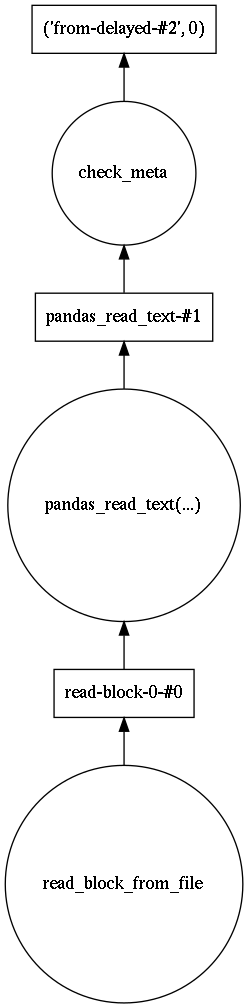

In [11]:
dot_graph(df_dd.dask)

In [12]:
## Inspect data set
df_dd.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0


In [13]:
df_dd.tail()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
541904,581587,22613,12,12/9/2011 12:50,0.85,12680.0
541905,581587,22899,6,12/9/2011 12:50,2.10,12680.0
541906,581587,23254,4,12/9/2011 12:50,4.15,12680.0
541907,581587,23255,4,12/9/2011 12:50,4.15,12680.0
541908,581587,22138,3,12/9/2011 12:50,4.95,12680.0


Dask can create dataframes from text delimited files, parquet files, HDFS (hadoop), and SQL connections (see documentation for further details). 


https://dask.pydata.org/en/latest/

In [14]:
# Create a copy of the dataframe to be used momentarily
df_dd2 = df_dd.copy()

## Dataframe operations

We might like to describe the underlying data. There is a describe method as usual, but it uses delayed execution. We can force the execution using `.compute()`

In [15]:
## This requires a compute
df_dd.describe().compute()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data types

Dask dataframes use the same sort of data types as the underlying pandas dataframes. 

In [16]:
## Inspect data types
df_dd.dtypes

InvoiceNo       object
StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
dtype: object

## Creating new variables

We can create new variables as before in pandas like so:

In [17]:
## create a new column
df_dd['Test1'] = 1
## Delete column
del df_dd['Test1']

Notice however, once we inspect the dataframe objects, we seem to be accumulating tasks. This is the result of the lazy evaluation and quite intentional. 

In [ ]:
x[0][0]

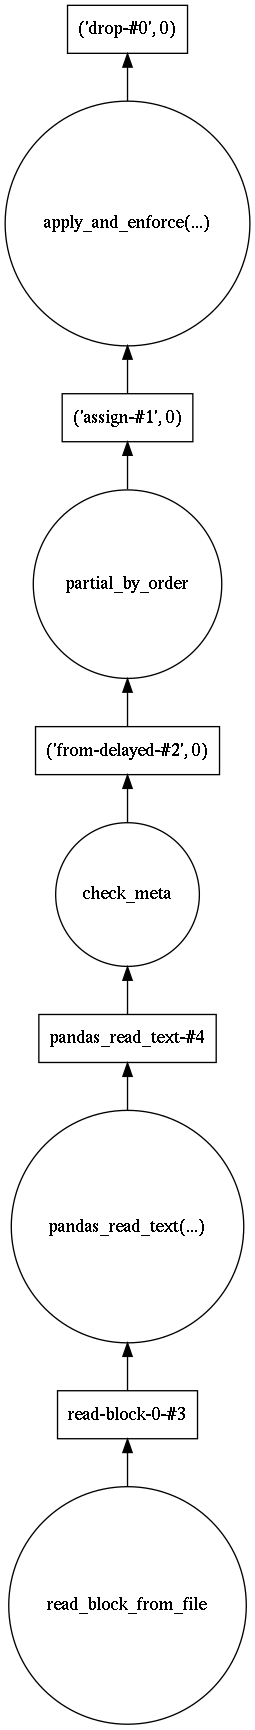

In [18]:
df_dd
dot_graph(df_dd.dask)

Let's create a new datetime column. We can use the similar syntax we would use with pandas. The execution seems instant, but only because evaluation has not occured yet. 

In [19]:
# Create a date time column
df_dd['InvoiceDate_dt'] = dd.to_datetime(df_dd['InvoiceDate'],
     format = '%m/%d/%Y %H:%M')

In [20]:
# Create a formatted date (month)
df_dd['InvoiceMonth'] = df_dd['InvoiceDate_dt'].dt.strftime('%m')

Now we can examine the head of the two different files (the original copy, and the dataframe with all the tasks piled up). Notice the difference in exectution speed. The head method forces evaluation:

In [21]:
## Notice the speed difference
df_dd.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


In [22]:
df_dd2.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0


## Persisting a dataframe

It is entirely possible we want to set up a bunch of initial tasks, then look at various different summaries of the data after those tasks. In that case, it seems odd to have to cosntantly request the full evaluation. We can 'persist' the dataframe, requesting evaluation of tasks and storing the resulting dataframe. The method is simply persist:

In [23]:
# Persist this dataframe
df_dd_p = df_dd.persist()
#df_dd.head()


In [25]:
%time df_dd.head() # this run took almost 4 seconds

CPU times: user 4.81 s, sys: 124 ms, total: 4.93 s
Wall time: 8.47 s


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


In [26]:
%timeit df_dd_p.head() ## with the persisted data, 1 ms

2.06 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##  Subsetting

Subsetting works as expected in pandas. 

In [28]:
# Subset by Boolean
df_dd_p[df_dd_p.UnitPrice < 0].head()

/home/ra/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 5 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
299983,A563186,B,1,8/12/2011 14:51,-11062.06,NaN,2011-08-12 14:51:00,08
299984,A563187,B,1,8/12/2011 14:52,-11062.06,NaN,2011-08-12 14:52:00,08


In [29]:
# Use .loc 
df_dd_p.loc[df_dd_p.Quantity < 10, ['InvoiceNo', 'Quantity', 'CustomerID']]

,InvoiceNo,Quantity,CustomerID
npartitions=1,,,
,object,int64,float64
,...,...,...


In [30]:
# Need to request a compute!
df_dd_p.loc[df_dd_p.Quantity < 10, ['InvoiceNo', 'Quantity', 'CustomerID']].compute()

,InvoiceNo,Quantity,CustomerID
0,536365,6,17850.0
1,536365,6,17850.0
2,536365,8,17850.0
3,536365,6,17850.0
4,536365,6,17850.0
...,...,...,...
541903,581587,4,12680.0
541905,581587,6,12680.0
541906,581587,4,12680.0
541907,581587,4,12680.0


The compute we just asked for pulled the entire result into memory and printed. Perhaps we just wanted to know the number of rows that met this condition? We can use count...

In [31]:
df_dd_p.loc[df_dd_p.Quantity < 10, ['InvoiceNo', 'Quantity', 'CustomerID']].count().compute()

InvoiceNo     386990
Quantity      386990
CustomerID    259304
dtype: int64

## Compute versus Persist

Compute and persist are similar but different! 
* `.compute()` will request all evaluations and pull the result into memory as a Pandas dataframe (be careful with big data...). 
* `.persist()` requests evaluations and places a marker to the results, so you can keep it out of memory. 

## Group By Functionality

Groupy by works syntactically just as it does in Pandas:

In [32]:
# Perform a group by summary 
%timeit df_dd_p.groupby(['InvoiceMonth','CustomerID']).Quantity.sum().head()


95.5 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Performance

For performant analysis within a data frame context, Dask recommends indexing your data and using the index for super-efficient indexing, grouping, joins, and the like. However, don't reindex more than necessary. Indexing or re-indexing requires a disk shuffle, which is performatively "costly."

After you set the index (and incur a shuffle), *persist* your data.

In [33]:
df_dd_p.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


## Set the Index

In [34]:
%time df_dd_p.set_index('InvoiceMonth')


CPU times: user 556 ms, sys: 0 ns, total: 556 ms
Wall time: 753 ms


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt
npartitions=1,,,,,,,
01,object,object,int64,object,float64,float64,datetime64[ns]
12,...,...,...,...,...,...,...


In [41]:
%time df_dd_p.groupby(['InvoiceMonth','CustomerID'])['Quantity'].sum().head()

CPU times: user 64 ms, sys: 16 ms, total: 80 ms
Wall time: 168 ms


InvoiceMonth  CustomerID
01            12346.0          0
              12347.0        315
              12348.0        601
              12356.0       1216
              12359.0        144
Name: Quantity, dtype: int64

## Persist your data

After a reindex, it's recommended to persist your data.

In [36]:
df_dd_pp = df_dd_p.persist()

## Repartition your data

Commonly, we load our data into memory and then filter it down to a fraction of the original dataset. Dask recommends `repartition`ing your data to regroup many small partitions into fewer larger ones.

In [37]:
df_dd_pp.UnitPrice.describe().compute()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
dtype: float64

In [42]:
df_dd_lowerHalf = df_dd_pp[df_dd_pp['UnitPrice'] < 2]
df_dd_lowerHalf.compute()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
7,536366,22633,6,12/1/2010 8:28,1.85,17850.0,2010-12-01 08:28:00,12
8,536366,22632,6,12/1/2010 8:28,1.85,17850.0,2010-12-01 08:28:00,12
9,536367,84879,32,12/1/2010 8:34,1.69,13047.0,2010-12-01 08:34:00,12
13,536367,22310,6,12/1/2010 8:34,1.65,13047.0,2010-12-01 08:34:00,12
29,536370,21724,12,12/1/2010 8:45,0.85,12583.0,2010-12-01 08:45:00,12
...,...,...,...,...,...,...,...,...
541895,581587,22556,12,12/9/2011 12:50,1.65,12680.0,2011-12-09 12:50:00,12
541896,581587,22555,12,12/9/2011 12:50,1.65,12680.0,2011-12-09 12:50:00,12
541901,581587,22367,8,12/9/2011 12:50,1.95,12680.0,2011-12-09 12:50:00,12
541902,581587,22629,12,12/9/2011 12:50,1.95,12680.0,2011-12-09 12:50:00,12


In [43]:
df_dd_lowerHalf.npartitions 
#we only have one partition here, so it doesn't make sense to repartition

1

But if we had a larger data set, we would repartition like so... the docs recommend aiming for partitions of size about 100MB each, and repartitioning just before doing a shuffle (reindex) as well. 

In [46]:
 df = df.repartition(npartitions=df.npartitions // 100)

## Joins

Dask joins are 'cheap' when
- joining a dask dataframe with a pandas dataframe
- joining a dask dataframe to another dask df with a single partition
- joining dask dfs along their indexes

Dask joins are 'expensive' when
- joining dask df on columns that are not their index

## Saving out to HDF

Once you have read the csv file in, you may wish to save it out to a different format. CSV is a bit limited, and does not truly store all the data type information (like the date time we just created). HDF is very popular with Pandas and Python, so we will show that here. You could also use Parquet, or other format detailed on the dask help.

In [57]:
# Save to hdf file
df_dd_p.to_hdf(r'temp/test-1.hdf',key='/InvoiceMonth')

['temp/test-1.hdf']

In [58]:
# Read in the file
df_dd3 = dd.read_hdf(r'temp/test-1.hdf',key='/InvoiceMonth')

In [59]:
# notice it is faster now (the evaluations occured and were saved to the HDF)
%time df_dd3.head()

CPU times: user 1.44 s, sys: 308 ms, total: 1.75 s
Wall time: 2.07 s


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


In [60]:
# The dtypes were preserved
df_dd3.dtypes

InvoiceNo                 object
StockCode                 object
Quantity                   int64
InvoiceDate               object
UnitPrice                float64
CustomerID               float64
InvoiceDate_dt    datetime64[ns]
InvoiceMonth              object
dtype: object

## Store to Parquet

While HDF is popular, Dask recommends storing to Parquet (http://dask.pydata.org/en/latest/dataframe-performance.html#store-data-in-apache-parquet-format)  
Parquet is another storage format, but it has a couple of advantages that make it play well with dask:
- simpler to deal with from the library's perspective
- stores *columnar* information, which can make retrieval much faster.  


In [1]:
df_dd_lowerHalf.to_parquet('data/')

NameError: name 'df_dd_lowerHalf' is not defined

In [67]:
%time df = dd.read_parquet('data/')

ValueError: Found files in an intermediate directory: data/

In [53]:
%time df.head()

Wall time: 1.45 s


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536366,22633,6,12/1/2010 8:28,1.85,17850.0,2010-12-01 08:28:00,12
1,536366,22632,6,12/1/2010 8:28,1.85,17850.0,2010-12-01 08:28:00,12
2,536367,84879,32,12/1/2010 8:34,1.69,13047.0,2010-12-01 08:34:00,12
3,536367,22310,6,12/1/2010 8:34,1.65,13047.0,2010-12-01 08:34:00,12
4,536370,21724,12,12/1/2010 8:45,0.85,12583.0,2010-12-01 08:45:00,12


In [54]:
df_dd_p.to_hdf(r'data/test1.hdf',key='/InvoiceMonth')

['data/test1.hdf']

In [55]:
df_dd3 = dd.read_hdf(r'data/test1.hdf',key='/InvoiceMonth')
%time df_dd3.head()

Wall time: 1.86 s


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


In [56]:
df_dd_p.to_parquet(r'data/pq/')

In [57]:
dfpq = dd.read_parquet(r'data/pq/')
%time dfpq.head()

Wall time: 356 ms


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDate_dt,InvoiceMonth
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,2010-12-01 08:26:00,12
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,2010-12-01 08:26:00,12
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,2010-12-01 08:26:00,12


In this case, about 4 x better performance with parquet.

## Other use cases for Dask

In addition to performant data frame analysis with dask, dask provides other objects and methods. We note some of these briefly here:

Like the data frame, Dask provides a data array object that encapsulates numpy nd array functionality. Conceptually, it's similar to the dask data frame:

<img src="http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg">

In [58]:
import dask.array as da

In [14]:
big_a = np.random.normal(loc=42,scale=4.2,size=(10000,10000))

In [15]:
big_a.size

100000000

In [16]:
x = da.from_array(big_a, chunks=(1000, 1000))

## Time Comparisons

Numpy is fast of course, so whether you see performance enhancements depends on the size of your data, & the computations you seek to calculate.   

Below are some timed comparisons, just by way of example

In [17]:
%timeit da.sum(x).compute()

200 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit np.sum(big_a)

71.8 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit da.mean(x,axis=1).compute()

371 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit np.mean(big_a,axis=1)

70.2 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit da.mean(x[x>10]).compute()

1.36 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit np.mean(big_a[big_a>10])

567 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Task Graphs and Task Scheduling

Dask's strongest contribution to data analysis with Python, however, may be its ability to take *ordinary* python code and easily parallelize it. For algorithmic approaches that don't easily fall into a data frame *split-apply-combine* approach, dask promises to give a developer low-level control over task graph building and scheduling.

A task graph is a recipe or series of steps for the system to follow in the evaluation of an expression. We saw task graphs above as series of circles, boxes and arrows. Here's an example of task graph to split an array into 5 parts, carry out a multiplication, and sum the results.


For instance, from the dask documentation, we can take this simple code:


In [23]:
nn = np.random.randn(1000)
nn_da = da.from_array(nn, chunks=200)
res1 = da.sum(nn_da * 42)

In [24]:
res1.dask

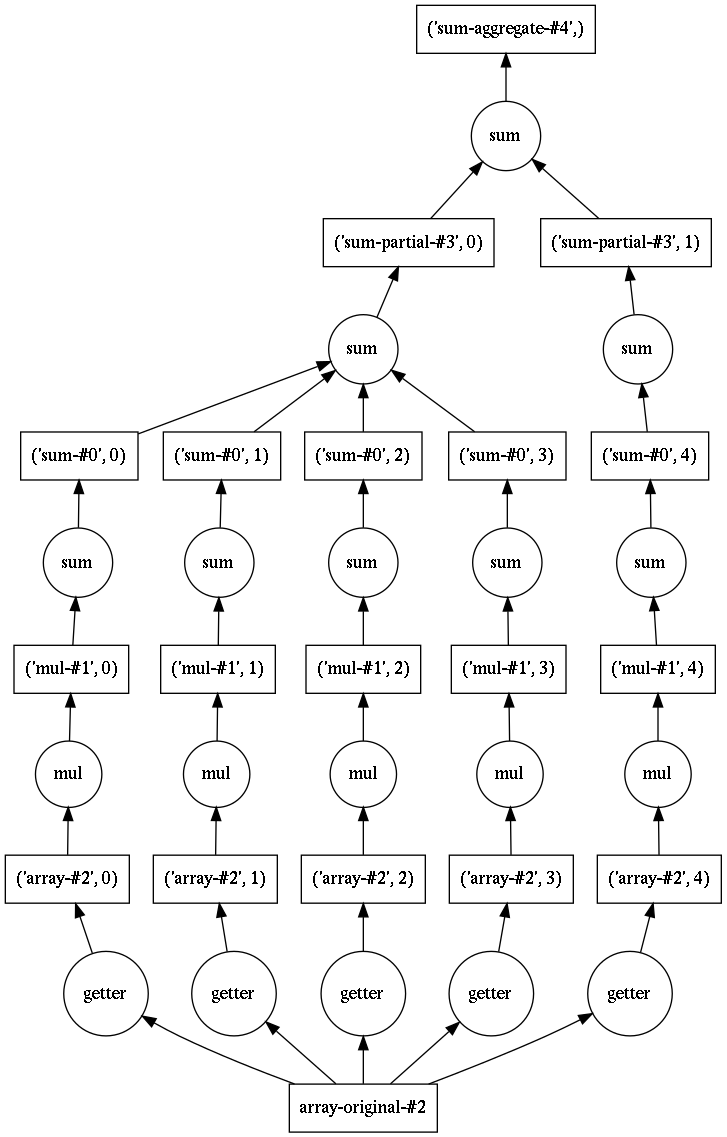

In [25]:
dot_graph(res1.dask)

What if instead we had the following procedural code?

In [26]:
def inc(i):
    return i + 1

def add(a, b):
    return a + b

x = 1
y = inc(x)
z = add(y, 10)

Dask can take this, and likewise build a task graph and then schedule the computation.

In [27]:
x = dask.delayed(inc)(1)
y = dask.delayed(inc)(x)
z = dask.delayed(add)(x,y)
z.compute()

5

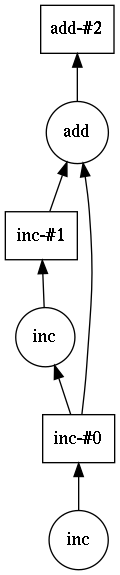

In [28]:
z.visualize()

## Comparison to PySpark, Luigi

Dask (from its creator) is intended to sit somewhere between a large, distributed system like PySpark and a low-level scheduler like Luigi. That is, it was originally designed to address parallelized numerical computations on a single computer, but it turns out it can run very well on a cluster. 

In comparison to Luigi, Dask does better with latency and inter-worker storage, and is optimized for computation.

Dask is  
- lightweight
- easy to integrate
- part of the Anaconda distro
- familiar, if you know Numpy and Pandas
- fast, especially in conjunction with the Parquet format
- does better than Spark at more complex computationally-intensive graphs 
- uses Pythonic API's (Numpy, Pandas, Joblib...)

For a more in-depth comparison to PySpark, read here: https://dask.pydata.org/en/latest/spark.html

For the author's comparison to multiprocessing, Spark, Luigi, and more, watch his 2017 presentation here: https://youtu.be/RA_2qdipVng?t=1420

## Even More

There is more to Dask-- task scheduling in particular. We encourage you to see if this product can fit into your workflow and extend your usage of Numpy and Pandas. Remember that Dask can scale to cluster computing as well. For more, check out the Dask documentation.

https://dask.pydata.org/en/latest/index.html